Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8184 - loss: 0.4001 - val_accuracy: 0.9370 - val_loss: 0.2305 - learning_rate: 0.0010
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9614 - loss: 0.1053 - val_accuracy: 0.8163 - val_loss: 0.6785 - learning_rate: 0.0010
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9591 - loss: 0.1013 - val_accuracy: 0.9351 - val_loss: 0.2139 - learning_rate: 0.0010
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9709 - loss: 0.0834 - val_accuracy: 0.8514 - val_loss: 0.4600 - learning_rate: 0.0010
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9716 - loss: 0.0697 - val_accuracy: 0.8283 - val_loss: 0.7684 - learning_rate: 0.0010
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9756 - loss: 0.0642 - val_accuracy: 0.9731 - val_loss: 0.0932 - learning_rate: 1.0000e-04
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9868 - loss: 0.0385 - 

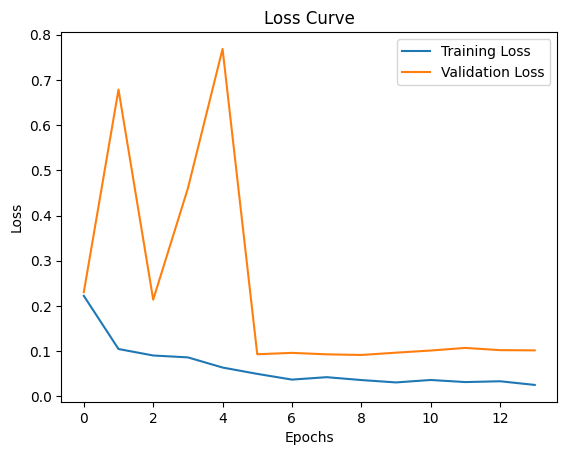

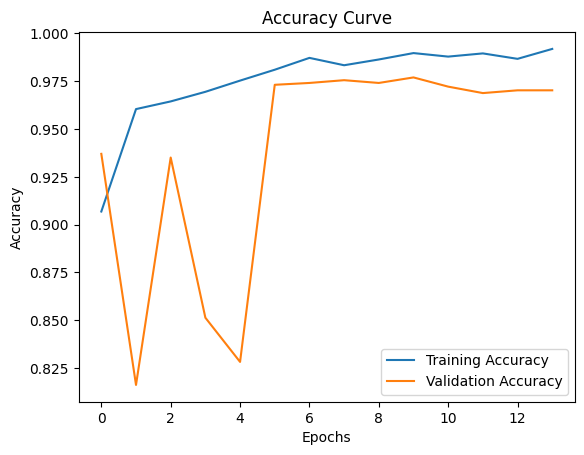

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load datasets
train_data = pd.read_csv('BATADAL_dataset04.csv')
test_data = pd.read_csv('BATADAL_test_dataset.csv')

# Replace -999 with 0 in the datasets
train_data.replace(-999, 0, inplace=True)
test_data.replace(-999, 0, inplace=True)

# Convert the first column (timestamp) to datetime
train_data['timestamp'] = pd.to_datetime(train_data.iloc[:, 0], format='%d/%m/%y %H')
test_data['timestamp'] = pd.to_datetime(test_data.iloc[:, 0], format='%d/%m/%y %H')

# Extract features from the timestamp
train_data['hour'] = train_data['timestamp'].dt.hour
train_data['day_of_week'] = train_data['timestamp'].dt.dayofweek
train_data['is_weekend'] = (train_data['day_of_week'] >= 5).astype(int)

test_data['hour'] = test_data['timestamp'].dt.hour
test_data['day_of_week'] = test_data['timestamp'].dt.dayofweek
test_data['is_weekend'] = (test_data['day_of_week'] >= 5).astype(int)

# Drop the original timestamp column
train_data.drop(columns=['timestamp', train_data.columns[0]], inplace=True)
test_data.drop(columns=['timestamp', test_data.columns[0]], inplace=True)

# Define features and labels
X_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

# Normalize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for LSTM (samples, timesteps, features)
time_steps = 10
def create_sequences(data, labels, time_steps):
    sequences, seq_labels = [], []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i + time_steps])
        seq_labels.append(labels[i + time_steps])
    return np.array(sequences), np.array(seq_labels)

X_train, y_train = create_sequences(X_train, y_train, time_steps)
X_test, y_test = create_sequences(X_test, y_test, time_steps)

# Handle imbalanced data using SMOTE
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
X_train = X_train.reshape(-1, time_steps, X_train.shape[1] // time_steps)

# Convert labels to categorical (for binary classification)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')  # 2 classes: attack and no attack
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch != 0:
        lr = lr * 0.1
    return lr

lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler_callback]
)

# Evaluate model
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(classification_report(y_test, y_pred))

# Plot training/validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Plot training/validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()